In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import geopandas as gpd
import osmnx as ox
import contextily as cx
import urbanpy as up
from tqdm.auto import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
gdf_celdas = gpd.read_parquet("outputs/gdf_celdas_final_2025_06_17.parquet")
gdf_celdas.head()

,cell_id,polygon_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,duration_to_nearest_primary_schools_label,distance_to_nearest_middle_schools,duration_to_nearest_middle_schools,duration_to_nearest_middle_schools_label,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,geometry
0,13887,02595-2-1,urban_area,bol,0.000000,0.000000,0.000000,0.000000,1.6730,20.075000,15-30,1.6730,20.075000,15-30,1.6730,20.075000,15-30,"POLYGON ((-69.57156 -10.95204, -69.57038 -10.9..."
1,13887,02595-2-1,urban_area,bra,29.889341,10.580689,9.581732,9.516878,1.6730,20.075000,15-30,1.6730,20.075000,15-30,1.6730,20.075000,15-30,"POLYGON ((-69.57156 -10.95204, -69.57038 -10.9..."
2,13956,08801-1-1,non_urban_area,bol,0.205296,0.071269,0.068739,0.069190,1.0347,12.415000,0-15,1.0347,12.415000,0-15,1.0347,12.415000,0-15,"POLYGON ((-69.21655 -11.14754, -69.21536 -11.1..."
3,13993,06399-1-1,non_urban_area,bol,4.057443,1.408542,1.358551,1.367463,0.2030,2.436667,0-15,0.2030,2.436667,0-15,0.2030,2.436667,0-15,"POLYGON ((-69.06537 -11.28604, -69.06416 -11.2..."
4,13998,08147-1-1,non_urban_area,bol,2.743381,0.952365,0.918565,0.924590,0.5786,6.943333,0-15,0.5786,6.943333,0-15,0.5786,6.943333,0-15,"POLYGON ((-69.02062 -11.18827, -69.01942 -11.1..."


In [3]:
gdf_celdas.columns

Index(['cell_id', 'polygon_id', 'category', 'country', 'pop_total',
       'pop_primary_school_age', 'pop_middle_school_age',
       'pop_secondary_school_age', 'distance_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools_label',
       'distance_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools_label',
       'distance_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools_label', 'geometry'],
      dtype='object')

In [4]:
print("Numer of cells without access:")
(
    gdf_celdas[
        [
            "duration_to_nearest_primary_schools_label",
            "duration_to_nearest_middle_schools_label",
            "duration_to_nearest_secondary_schools_label",
        ]
    ]
    == "No access"
).sum()

Numer of cells without access:


duration_to_nearest_primary_schools_label      1949
duration_to_nearest_middle_schools_label       1193
duration_to_nearest_secondary_schools_label    1727
dtype: int64

In [5]:
gdf_celdas[gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"][
    "category"
].value_counts()

category
non_urban_area    1756
urban_area         193
Name: count, dtype: int64

In [6]:
# Load amazon boundaries
amazon = gpd.read_file("/Users/claudio/Documents/amazonia-bid/inputs/Amazonas")
amazon.crs.to_string()

'ESRI:102033'

In [7]:
# Convert to mercator and get the polygon
amazon_poly = amazon.to_crs(4326).geometry[0]

In [8]:
# Load south american rivers. Source: https://www.hydrosheds.org/products/hydrorivers
south_american_rivers_gdf = gpd.read_parquet(
    "outputs/HydroRIVERS_v10_south_america.parquet"
)
south_american_rivers_gdf.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,60000001,0,60000001,0.97,0.0,6.5,3.73,3.7,0,0.109,1,1,7,6120035220,"LINESTRING (-61.125 14.86667, -61.11875 14.87292)"
1,60000002,0,60000002,1.16,0.0,5.3,4.98,5.0,0,0.147,1,2,7,6120035220,"LINESTRING (-61.11875 14.8625, -61.11875 14.87..."
2,60000003,0,60000003,3.37,0.0,7.2,8.09,7.5,0,0.217,1,1,7,6120035220,"LINESTRING (-61.15208 14.85, -61.15208 14.8645..."
3,60000004,0,60000004,3.37,0.0,6.3,11.41,11.2,0,0.329,1,1,7,6120035220,"LINESTRING (-61.17292 14.84583, -61.17292 14.8..."
4,60000005,0,60000005,3.07,0.0,7.9,6.64,6.4,0,0.187,1,1,7,6120035220,"LINESTRING (-61.11667 14.84375, -61.11042 14.8..."


In [9]:
# south_american_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_south_america.parquet"
# )

In [10]:
south_american_rivers_gdf.shape

(1620963, 15)

In [11]:
# Filter rivers within Amazon bounds
minx, miny, maxx, maxy = amazon_poly.bounds
amazon_rivers_gdf = south_american_rivers_gdf.cx[minx:maxx, miny:maxy]

In [12]:
# amazon_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_amazon.parquet"
# )

In [13]:
gdf_celdas.loc[:, "lon"] = gdf_celdas.centroid.x
gdf_celdas.loc[:, "lat"] = gdf_celdas.centroid.y

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_59817/438060475.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_celdas.loc[:, "lon"] = gdf_celdas.centroid.x
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_59817/438060475.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_celdas.loc[:, "lat"] = gdf_celdas.centroid.y


In [14]:
# Filter the isolate cells for each edu level
isolated_cells_primary = gdf_celdas[
    gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"
]
isolated_cells_secondary = gdf_celdas[
    gdf_celdas["duration_to_nearest_secondary_schools_label"] == "No access"
]
isolated_cells_middle = gdf_celdas[
    gdf_celdas["duration_to_nearest_middle_schools_label"] == "No access"
]

In [15]:
polygon_example = isolated_cells_primary.iloc[[100]]

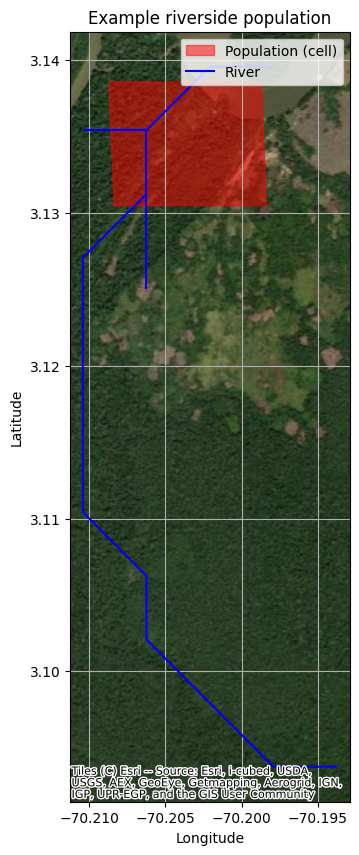

In [16]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
polygon_example.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5)

amazon_rivers_gdf[
    amazon_rivers_gdf.intersects(polygon_example.iloc[0]["geometry"])
].plot(ax=ax, color="blue")

# Add the basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Example riverside population")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

pop_patch = mpatches.Patch(color="red", label="Population (cell)", alpha=0.5)
river_line = mlines.Line2D([], [], color="blue", label="River")

ax.legend(handles=[pop_patch, river_line], loc="upper right")

# Show the plot
plt.show()

In [ ]:
isolated_cells_primary_proj = ox.project_gdf(isolated_cells_primary)
isolated_cells_middle_proj = ox.project_gdf(isolated_cells_middle)
isolated_cells_secondary_proj = ox.project_gdf(isolated_cells_secondary)
amazon_rivers_gdf_proj = amazon_rivers_gdf.to_crs(
    isolated_cells_primary_proj.crs.to_string()
)

In [ ]:
isolated_cells_primary_wrivers_proj = isolated_cells_primary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [ ]:
isolated_cells_primary_wrivers_proj.shape[0], isolated_cells_primary_proj.shape[0]

In [ ]:
isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum()

In [ ]:
isolated_cells_secondary_wrivers_proj = isolated_cells_secondary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [ ]:
isolated_cells_middle_wrivers_proj = isolated_cells_middle_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [ ]:
isolated_cells_primary_wrivers_proj

In [ ]:
data = {
    "Level": ["Primary", "Middle", "Secondary"],
    "Total isolated (= No Access)": [
        isolated_cells_primary_proj.shape[0],
        isolated_cells_middle_proj.shape[0],
        isolated_cells_secondary_proj.shape[0],
    ],
    "Not near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.isna().sum(),
    ],
    "Near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.notna().sum(),
    ],
}

df_summary = pd.DataFrame(data)
df_summary["% Not near river"] = round(
    100 * df_summary["Not near river"] / df_summary["Total isolated (= No Access)"], 2
)
df_summary

In [ ]:
# Calculate total population for each education level and river proximity
levels = ["Primary", "Middle", "Secondary"]
pop_columns = [
    (
        "isolated_cells_primary",
        "isolated_cells_primary_wrivers_proj",
        "pop_primary_school_age",
    ),
    (
        "isolated_cells_middle",
        "isolated_cells_middle_wrivers_proj",
        "pop_middle_school_age",
    ),
    (
        "isolated_cells_secondary",
        "isolated_cells_secondary_wrivers_proj",
        "pop_secondary_school_age",
    ),
]
results = []
for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    iso = globals()[iso_name]
    wriver = globals()[wriver_name]
    # Isolated: sum of pop_total in all isolated cells
    pop_isolated = iso[pop_col].sum()
    # Not near river: sum of pop_total where distance_to_river isna()
    pop_not_near_river = wriver[wriver["distance_to_river"].isna()][pop_col].sum()
    # Near river: sum of pop_total where distance_to_river is notna()
    pop_near_river = wriver[wriver["distance_to_river"].notna()][pop_col].sum()
    results.append(
        [level, int(pop_isolated), int(pop_not_near_river), int(pop_near_river)]
    )

df_pop_summary = pd.DataFrame(
    results,
    columns=[
        "Level",
        "Total isolated population",
        "Not near river population",
        "Near river population",
    ],
)
df_pop_summary

In [ ]:
amazon_rivers_gdf

In [ ]:
amazon_rivers_gdf_proj.shape

In [ ]:
amazon_rivers_gdf_proj["MAIN_RIV"].isin(
    isolated_cells_primary_wrivers_proj["MAIN_RIV"].dropna().unique()
).sum()

In [ ]:
amazon_rivers_gdf_proj["MAIN_RIV"].unique().shape

In [ ]:
isolated_cells_primary_wrivers_proj.isna().sum()

In [ ]:
amazon_schools = gpd.read_parquet("outputs/amazon_schools.parquet")
amazon_schools.head()

In [ ]:
amazon_schools.loc[:, "lon"] = amazon_schools.geometry.x
amazon_schools.loc[:, "lat"] = amazon_schools.geometry.y

In [ ]:
amazon_schools_primary = amazon_schools[amazon_schools["nivel_primaria"] == 1]
amazon_schools_middle = amazon_schools[amazon_schools["nivel_media"] == 1]
amazon_schools_secondary = amazon_schools[amazon_schools["nivel_secundaria"] == 1]

In [ ]:
amazon_schools_primary_proj = amazon_schools_primary.to_crs(amazon_rivers_gdf_proj.crs)
amazon_schools_middle_proj = amazon_schools_middle.to_crs(amazon_rivers_gdf_proj.crs)
amazon_schools_secondary_proj = amazon_schools_secondary.to_crs(
    amazon_rivers_gdf_proj.crs
)

In [ ]:
amazon_schools_primary_wrivers_proj = amazon_schools_primary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

amazon_schools_middle_wrivers_proj = amazon_schools_middle_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

amazon_schools_secondary_wrivers_proj = amazon_schools_secondary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=500,
    distance_col="distance_to_river",  # 1km
).dropna(subset="distance_to_river")

In [ ]:
amazon_schools_primary_wrivers = amazon_schools_primary_wrivers_proj.to_crs(4326)
amazon_schools_middle_wrivers = amazon_schools_middle_wrivers_proj.to_crs(4326)
amazon_schools_secondary_wrivers = amazon_schools_secondary_wrivers_proj.to_crs(4326)

In [ ]:
print(
    str(
        amazon_schools_primary_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " primary schools within 500m of a river that intersect with the example polygon"
)

print(
    str(
        amazon_schools_middle_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " middle schools within 500m of a river that intersect with the example polygon"
)

print(
    str(
        amazon_schools_secondary_wrivers.intersects(
            polygon_example.iloc[0]["geometry"].buffer(0.1)
        ).sum()
    )
    + " secondary schools within 500m of a river that intersect with the example polygon"
)

In [ ]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
polygon_example.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5)

amazon_rivers_gdf[
    amazon_rivers_gdf.intersects(polygon_example.iloc[0]["geometry"])
].plot(ax=ax, color="blue")

amazon_schools_primary_wrivers[
    amazon_schools_primary_wrivers.intersects(
        polygon_example.iloc[0]["geometry"].buffer(0.1)
    )
].plot(ax=ax, color="orange")

# Add the basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Example riverside population")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

pop_patch = mpatches.Patch(color="red", label="Population (cell)", alpha=0.5)
river_line = mlines.Line2D([], [], color="blue", label="River")
school_point = mlines.Line2D(
    [], [], color="orange", label="Schools < 500m River", linewidth=0, marker="o"
)

ax.legend(handles=[pop_patch, river_line, school_point], loc="upper right")

# Show the plot
plt.show()

In [ ]:
isolated_cells_primary_wrivers = isolated_cells_primary_wrivers_proj.to_crs(4326)
isolated_cells_middle_wrivers = isolated_cells_middle_wrivers_proj.to_crs(4326)
isolated_cells_secondary_wrivers = isolated_cells_secondary_wrivers_proj.to_crs(4326)

In [ ]:
isolated_cells_primary_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_primary_wrivers,
    amazon_schools_primary_wrivers,
    col_label="nearest_primary_school_by_river",
)

In [ ]:
isolated_cells_middle_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_middle_wrivers,
    amazon_schools_middle_wrivers,
    col_label="nearest_middle_school_by_river",
)

In [ ]:
isolated_cells_secondary_wrivers_ttimes = up.accessibility.travel_times(
    isolated_cells_secondary_wrivers,
    amazon_schools_secondary_wrivers,
    col_label="nearest_secondary_school_by_river",
)

In [ ]:
print(
    "Isolated cells (No access to primary schools by land)",
    isolated_cells_primary_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to primary schools but accessible by river)",
    isolated_cells_primary_wrivers_ttimes.shape[0]
    - isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to primary schools by land nor river)",
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ]
    .isna()
    .sum(),
)

In [ ]:
isolated_cells_primary_wrivers_ttimes[
    "duration_to_nearest_nearest_primary_school_by_river_label"
].value_counts().sort_index()

In [ ]:
print(
    "Isolated cells (No access to middle schools by land)",
    isolated_cells_middle_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to middle schools but accessible by river)",
    isolated_cells_middle_wrivers_ttimes.shape[0]
    - isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to middle schools by land nor river)",
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ]
    .isna()
    .sum(),
)

In [ ]:
isolated_cells_middle_wrivers_ttimes[
    "duration_to_nearest_nearest_middle_school_by_river_label"
].value_counts().sort_index()

In [ ]:
print(
    "Isolated cells (No access to secondary schools by land)",
    isolated_cells_secondary_wrivers_ttimes.shape[0],
)
print(
    "Isolated cells (No access to secondary schools but accessible by river)",
    isolated_cells_secondary_wrivers_ttimes.shape[0]
    - isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ]
    .isna()
    .sum(),
)
print(
    "Isolated cells (No access to secondary schools by land nor river)",
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ]
    .isna()
    .sum(),
)

In [ ]:
isolated_cells_primary_wrivers_ttimes.columns

In [ ]:
# Calculate population for the three categories for primary level:
# 1. Total isolated (all rows in isolated_cells_primary_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_primary_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_primary_wrivers_proj)

pop_isolated_primary = isolated_cells_primary_wrivers_ttimes[
    "pop_primary_school_age"
].sum()
pop_not_near_river_primary = isolated_cells_primary_wrivers_ttimes[
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ].isna()
]["pop_primary_school_age"].sum()
pop_near_river_primary = isolated_cells_primary_wrivers_ttimes[
    isolated_cells_primary_wrivers_ttimes[
        "duration_to_nearest_nearest_primary_school_by_river_label"
    ].notna()
]["pop_primary_school_age"].sum()

print("Total Primary level population:")
print("No access by land:", int(pop_isolated_primary))
print("No access by land nor river:", int(pop_not_near_river_primary))
print("No access by river but no land:", int(pop_near_river_primary))

print("\nMiddle level:")

# Calculate population for the three categories for middle level:
# 1. Total isolated (all rows in isolated_cells_middle_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_middle_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_middle_wrivers_proj)

pop_isolated_middle = isolated_cells_middle_wrivers_ttimes[
    "pop_middle_school_age"
].sum()
pop_not_near_river_middle = isolated_cells_middle_wrivers_ttimes[
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ].isna()
]["pop_middle_school_age"].sum()
pop_near_river_middle = isolated_cells_middle_wrivers_ttimes[
    isolated_cells_middle_wrivers_ttimes[
        "duration_to_nearest_nearest_middle_school_by_river_label"
    ].notna()
]["pop_middle_school_age"].sum()

print("Total population without access by land:", int(pop_isolated_middle))
print("No access by land nor river:", int(pop_not_near_river_middle))
print("No access by river but no land:", int(pop_near_river_middle))

print("\nSecondary level:")


# Calculate population for the three categories for secondary level:
# 1. Total isolated (all rows in isolated_cells_secondary_proj)
# 2. Not near river (distance_to_river isna in isolated_cells_secondary_wrivers_proj)
# 3. Near river (distance_to_river notna in isolated_cells_secondary_wrivers_proj)

pop_isolated = isolated_cells_secondary_wrivers_ttimes["pop_secondary_school_age"].sum()
pop_not_near_river = isolated_cells_secondary_wrivers_ttimes[
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ].isna()
]["pop_secondary_school_age"].sum()
pop_near_river = isolated_cells_secondary_wrivers_ttimes[
    isolated_cells_secondary_wrivers_ttimes[
        "duration_to_nearest_nearest_secondary_school_by_river_label"
    ].notna()
]["pop_secondary_school_age"].sum()

print("Total population without access by land:", int(pop_isolated))
print("No access by land nor river:", int(pop_not_near_river))
print("No access by river but no land:", int(pop_near_river))

# Put a phrase like "In total more than X school-age children live completely isolated from their corresponding schools

print(
    "\nIn total, more than "
    + str(
        int(pop_not_near_river_middle + pop_not_near_river_primary + pop_not_near_river)
    )
    + " school-age children live completely isolated from their corresponding schools."
)

In [ ]:
16773 + 20903 + 16351

In [ ]:
8331 + 3926 + 5408

In [ ]:
isolated_cells_secondary_wrivers_ttimes[
    "duration_to_nearest_nearest_secondary_school_by_river_label"
].value_counts().sort_index()

In [ ]:
isolated_cells_secondary_wrivers_ttimes

In [ ]:
# Calculate population by education level, type of access (no access, only by river), and country
pop_access_summary = []

for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    wriver_ttimes = globals()[f"{wriver_name.replace('_proj', '')}_ttimes"]
    # Group by country for both no access and only by river
    for country, group in wriver_ttimes.groupby("country"):
        # No access by land nor river: duration label isna
        pop_no_access = group[
            group[
                f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
            ].isna()
        ][pop_col].sum()
        # Only by river: duration label is notna
        pop_only_by_river = group[
            group[
                f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
            ].notna()
        ][pop_col].sum()
        pop_access_summary.append(
            [level, country, int(pop_no_access), int(pop_only_by_river)]
        )

df_pop_access_summary_country = pd.DataFrame(
    pop_access_summary,
    columns=["Level", "Country", "No access (land nor river)", "Only by river"],
)
df_pop_access_summary_country

In [ ]:
# Analyze populations with only river access per education level, travel time label, and country

pop_river_access_by_time = []

for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    wriver_ttimes = globals()[f"{wriver_name.replace('_proj', '')}_ttimes"]
    label_col = f"duration_to_nearest_nearest_{level.lower()}_school_by_river_label"
    # Only cells with access by river (label notna)
    df = wriver_ttimes[wriver_ttimes[label_col].notna()]
    summary = (
        df.groupby([label_col, "country"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "population"})
    )
    summary["Level"] = level
    pop_river_access_by_time.append(summary)

# Concatenate results for all levels
df_pop_river_access_by_time = pd.concat(pop_river_access_by_time, ignore_index=True)
df_pop_river_access_by_time

In [ ]:
df_pop_river_access_by_time.columns

In [ ]:
# Clean df_pop_river_access_by_time: unify travel time label column and set MultiIndex

# Find the travel time label column (it starts with 'duration_to_nearest_nearest_')
label_cols = [col for col in df_pop_river_access_by_time.columns if col.startswith('duration_to_nearest_nearest_')]

# Rename the travel time label column to 'travel_time_label'
df_pop_river_access_by_time_clean = df_pop_river_access_by_time.rename(
    columns={label_cols[0]: 'travel_time_label'}
)

# Fill na values in the travel time label column with the other travel time label columns
df_pop_river_access_by_time_clean['travel_time_label'] = (
    df_pop_river_access_by_time_clean['travel_time_label']
        .fillna(df_pop_river_access_by_time_clean[label_cols[1]])
        .fillna(df_pop_river_access_by_time_clean[label_cols[2]])
    )

# Drop the other travel time label columns
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.drop(columns=label_cols[1:])

# Set MultiIndex (Level, Country, travel_time_label)
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.set_index(['Level', 'country', 'travel_time_label'])

# Optional: sort index for better Excel analysis
df_pop_river_access_by_time_clean = df_pop_river_access_by_time_clean.sort_index()

df_pop_river_access_by_time_clean["population"] = df_pop_river_access_by_time_clean["population"].round().astype(int)

df_pop_river_access_by_time_clean

In [ ]:
df_pop_river_access_by_time_clean.to_clipboard()

In [ ]:
import seaborn as sns

# Reset index for plotting
df_plot = df_pop_river_access_by_time_clean.reset_index()

g = sns.catplot(
    data=df_plot,
    x="travel_time_label",
    y="population",
    hue="Level",
    col="country",
    kind="bar",
    height=6,
    aspect=1.2,
    col_wrap=3,
    sharex=True,
    sharey=True,
)
g.figure.suptitle("Travel time to nearest school by river (minutes)")
g.set(yscale="log")
g.set_axis_labels("", "Population")
g.set_titles("{col_name}")

# Add horizontal grid lines
for ax in g.axes.flatten():
    # Add horizontal lines at 100 and 1000
    ax.axhline(100, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        100,
        "Population = 100",
        color="gray",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )
    ax.axhline(1000, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        1000,
        "Population = 1000",
        color="k",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )
    ax.axhline(10000, color="gray", linestyle=":", linewidth=1)
    ax.text(
        0.99,
        10000,
        "Population = 10,000",
        color="k",
        fontsize=10,
        va="bottom",
        ha="right",
        transform=ax.get_yaxis_transform(),
        alpha=0.7,
    )


plt.tight_layout()
plt.show()

In [ ]:
df_pop_river_access_by_time_clean.to_excel(
    "outputs/riverside_pop_school_access_2025_06_26.xlsx", index=True
)

In [ ]:
df_pop_river_access_by_time_clean.sum()

In [ ]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("country")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("country")["population"].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

In [ ]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("Level")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("Level")["population"].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

In [ ]:
pd.DataFrame(
    {
        "population": df_pop_river_access_by_time_clean.groupby("travel_time_label")[
            "population"
        ].sum(),
        "% of total population": (
            (
                df_pop_river_access_by_time_clean.groupby("travel_time_label")[
                    "population"
                ].sum()
                / df_pop_river_access_by_time_clean["population"].sum()
                * 100
            ).round(2)
        ),
    }
)

In [ ]:
df_pop_river_access_by_time_clean.reset_index()["travel_time_label"]

In [ ]:
df_pop_river_access_by_time_clean[
    (
        df_pop_river_access_by_time_clean.reset_index()["travel_time_label"] > "15-30"
    ).values
]["population"].sum()

In [ ]:
# Isolated cells (No access to primary schools by land) 1919
# Isolated cells (No access to primary schools but accessible by river) 1139
# Isolated cells (No access to primary schools by land nor river) 780

# Isolated cells (No access to middle schools by land) 1162
# Isolated cells (No access to middle schools but accessible by river) 847
# Isolated cells (No access to middle schools by land nor river) 315

# Isolated cells (No access to secondary schools by land) 1696
# Isolated cells (No access to secondary schools but accessible by river) 1088
# Isolated cells (No access to secondary schools by land nor river) 608